# Time Series

In [8]:
import os
import librosa as lr
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

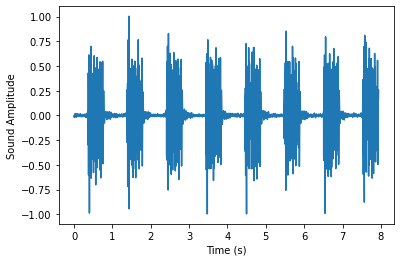

In [9]:
audio, sfreq = lr.load('../input/heartbeat-sounds/set_a/murmur__201108222243.wav')
time = np.arange(0, audio.shape[0])/sfreq
fig, ax = plt.subplots()
ax.plot(time, audio)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Sound Amplitude')
plt.show()

In [10]:
data = pd.read_csv('../input/nyse/prices.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [11]:
close = data[['symbol', 'close']].pivot(columns='symbol', values='close')
df = close[['AAPL', 'FB', 'NFLX', 'V', 'XOM']]

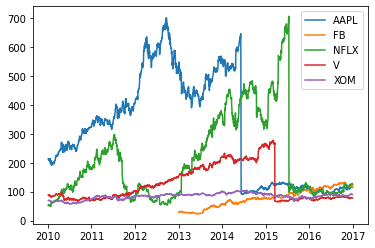

In [12]:
fig, ax = plt.subplots()
for c in df.columns:
    ax.plot(df[c], label=c)
ax.legend()
plt.show()

## Time Series as input for Model : Classification

In [13]:
set_a = pd.read_csv('../input/heartbeat-sounds/set_a.csv')

In [14]:
normal_f = set_a[set_a['label'] == 'normal'].sample(n=30, random_state=0)
abnormal_f = set_a[(set_a['label'] != 'normal') & (set_a['label'].notna())].sample(n=30, random_state=0)

In [15]:
def concat_wave(normal_f):    
    wave_list = []
    min_size = 1e6
    for r in normal_f.itertuples():
        w, f = lr.load(os.path.join('../input/heartbeat-sounds', r.fname))
        min_size = w.shape[0] if w.shape[0] < min_size else min_size
        wave_list.append(w)
    wave_list_match = []
    for w in wave_list:
        wave_list_match.append(w[:min_size])
    wave_df = np.column_stack(wave_list_match)
    return wave_df, f

In [16]:
normal, f_n = concat_wave(normal_f)
abnormal, f_ab = concat_wave(abnormal_f)

IndexError: index 3 is out of bounds for axis 0 with size 3

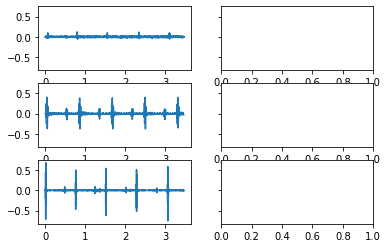

In [17]:
fig, ax = plt.subplots(3, 2, sharey=True)
for i in range(normal.shape[1]):
    time = np.arange(normal.shape[0]) / f_n
    ax[i, 0].plot(time, normal[:,i])
for j in range(abnormal.shape[1]):
    time = np.arange(abnormal.shape[0]) / f_ab
    ax[j, 1].plot(time, abnormal[:,j])
plt.show()

### Summary data by time index
to identify pattern in time seris data  

In [18]:
normal_df = pd.DataFrame(data=normal[:8820, :])
abnormal_df = pd.DataFrame(data=abnormal[:8820, :])
normal_df.to_csv('normal_df.csv')
abnormal_df.to_csv('abnormal_df.csv')

In [19]:
normal_df = pd.read_csv('normal_df.csv', index_col=0)
abnormal_df = pd.read_csv('abnormal_df.csv', index_col=0)

In [20]:
mean_normal = np.mean(normal_df, axis=1)
mean_abnormal = np.mean(abnormal_df, axis=1)

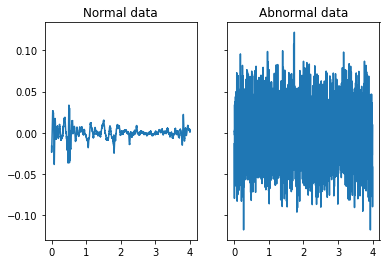

In [21]:
fig, ax = plt.subplots(1, 2, sharey=True)
time = np.arange(mean_normal.shape[0]) / 2205
ax[0].plot(time, mean_normal)
ax[0].set_title('Normal data')
ax[1].plot(time, mean_abnormal)
ax[1].set_title('Abnormal data')
plt.show()

## Classification

In [22]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

X = pd.concat([normal_df, abnormal_df], axis=1).to_numpy().T
y = np.array(normal_df.shape[1]*['normal'] + abnormal_df.shape[1]*['abnormal'])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

clf = LinearSVC()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5333333333333333

## Features engineering Sound data  
- `Sound envelop` : Moving average of amplitude  
- `Rectify` : Absolute amplitude

In [23]:
time = normal_df.shape[0]/2205
wave = normal_df[['0']]

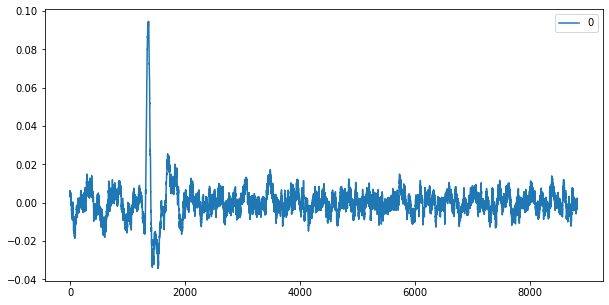

In [24]:
wave.plot(figsize=(10, 5))
plt.show()

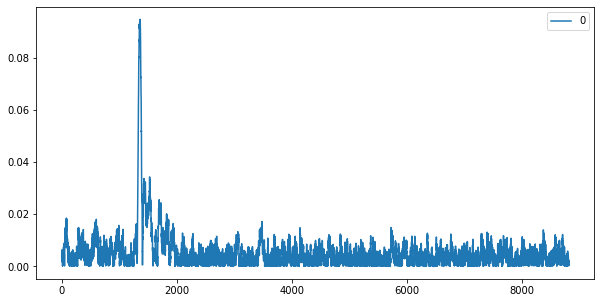

In [25]:
ractify_wave = wave.abs()
ractify_wave.plot(figsize=(10,5))
plt.show()

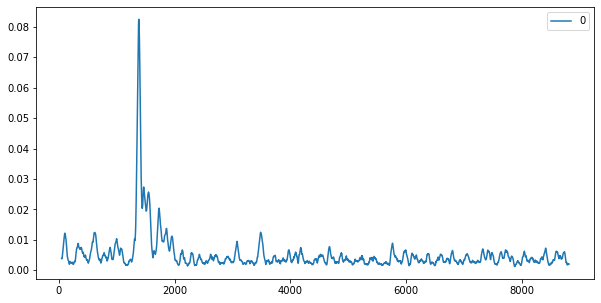

In [26]:
ractify_envelop = ractify_wave.rolling(50).mean()
ractify_envelop.plot(figsize=(10, 5))
plt.show()

In [27]:
sound = pd.concat([normal_df, abnormal_df], axis=1)
sound.columns = [*range(sound.shape[1])]
label = np.array(normal_df.shape[1]*['normal'] + abnormal_df.shape[1]*['abnormal'])

normal_ractify_smooth = sound.apply(np.abs).rolling(50).mean()

means = normal_ractify_smooth.mean(axis=0)
stds = normal_ractify_smooth.std(axis=0)
maxs = normal_ractify_smooth.max(axis=0)

X = np.column_stack([means, stds, maxs])
y = label

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC

In [29]:
clf = LinearSVC()
cv_score = cross_val_score(clf, X, y, cv=5)
print(f'Average each validation score : {np.mean(cv_score)}')

Average each validation score : 0.6166666666666668


### Derived features `Tempo`

In [30]:
tempos = []
for col in sound.columns:
    tempos.append(lr.beat.tempo(sound[col].to_numpy(), sr=2205, hop_length=2**6, aggregate=None))
tempos = np.array(tempos)
tempos_mean = tempos.mean(axis=1)
tempos_std = tempos.std(axis=1)
tempos_max = tempos.max(axis=1)

/opt/conda/lib/python3.7/site-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


In [31]:
X = np.column_stack([means, stds, maxs, tempos_max, tempos_mean, tempos_std])
cv_score = cross_val_score(clf, X, y, cv=5)
print(cv_score.mean())

0.5166666666666667


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

## Spectogram  
- Rolling Short Furier Transform

In [32]:
from librosa.core import stft
wave = normal_df['4']

HOP_LENGTH = 2**4
spec = stft(wave.to_numpy(), hop_length=HOP_LENGTH, n_fft=2**7)

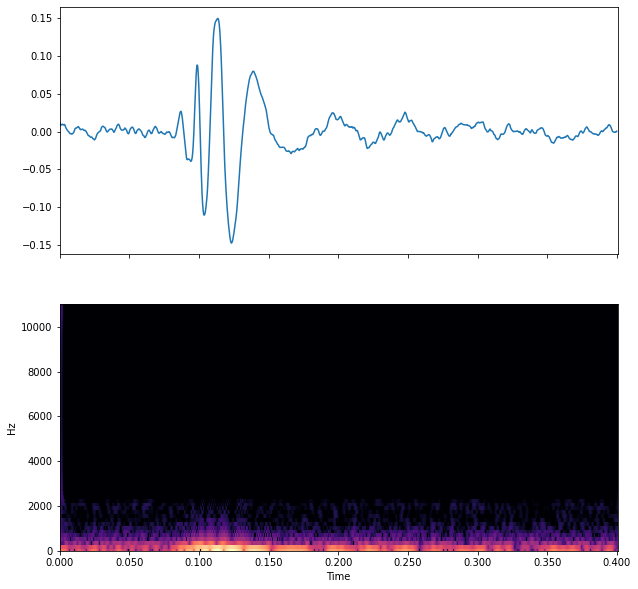

In [33]:
from librosa.core import amplitude_to_db
from librosa.display import specshow

spec_db = amplitude_to_db(np.abs(spec))
sfreq = 22050

fig, ax = plt.subplots(2,1, figsize=(10,10), sharex=True)
time = np.arange(wave.shape[0])/sfreq
ax[0].plot(time, wave.to_numpy())
specshow(spec_db, sr=sfreq, x_axis='time', y_axis='hz', hop_length=HOP_LENGTH)
plt.show()

In [34]:
import librosa as lr
bandwidths = lr.feature.spectral_bandwidth(S=np.abs(spec))[0]
controids = lr.feature.spectral_centroid(S=np.abs(spec))[0]

AttributeError: 'QuadMesh' object has no attribute 'plot'

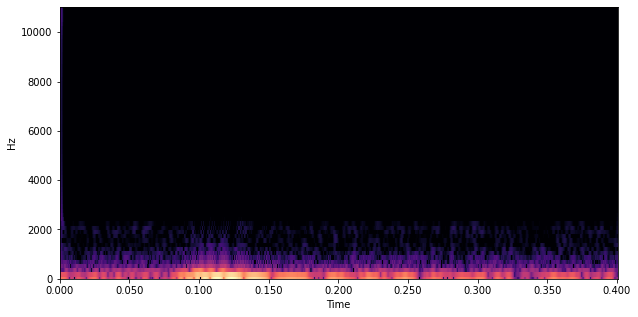

In [35]:
# Display these features on top of the spectrogram
fig, ax = plt.subplots(figsize=(10, 5))
ax = specshow(spec_db, x_axis='time', y_axis='hz', hop_length=HOP_LENGTH)
ax.plot(spec, centroids)
ax.fill_between(time_spec, centroids - bandwidths / 2, centroids + bandwidths / 2, alpha=.5)
ax.set(ylim=[None, 6000])
plt.show()

# Predict data overtime

In [36]:
data = pd.read_csv('../input/nyse/prices.csv', index_col=0)
data.index = pd.to_datetime(data.index)

In [37]:
prices  = (
    data
    .query("symbol in ('EBAY', 'YHOO')", engine='python')
    .loc[:,['symbol', 'close']]
    .pivot(columns='symbol', values='close')
)

<AxesSubplot:xlabel='date'>

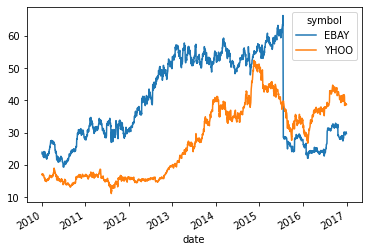

In [38]:
prices.plot()

<AxesSubplot:xlabel='EBAY', ylabel='YHOO'>

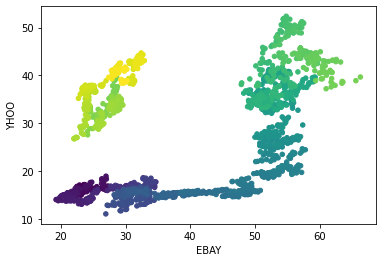

In [39]:
prices.plot.scatter('EBAY', 'YHOO', c=prices.index, cmap='viridis')

In [40]:
prices = (
    data
    .query("symbol in ('EBAY', 'NVDA', 'YHOO', 'AAPL')", engine='python')
    .loc[:, ['symbol','close']]
    .pivot(columns='symbol', values='close')
)

X = prices[['EBAY', 'NVDA', 'YHOO']]
y = prices[['AAPL']]

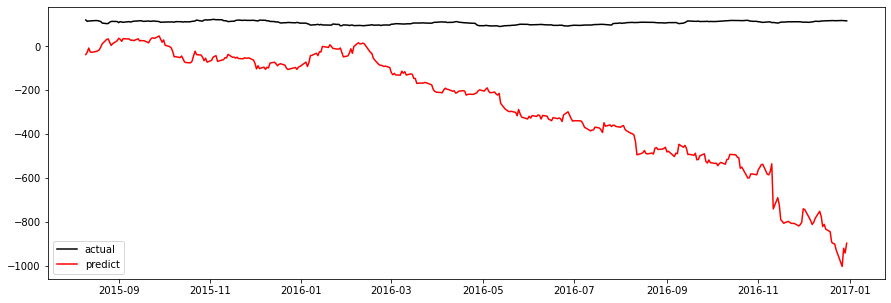

In [41]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score

reg = Ridge()
cv_score = cross_val_score(reg, X, y, cv=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, shuffle=False, random_state=1)
reg = Ridge()
reg.fit(X_train, y_train)
r2_score(reg.predict(X_test), y_test)

prediction = pd.DataFrame(data = reg.predict(X_test), index=y_test.index)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(y_test, c='k', label='actual')
ax.plot(prediction, c='r', label='predict')
ax.legend()
plt.show()

### Missing & Outlier : Interpoation, Moving average

In [42]:
prices.isna().sum()

symbol
AAPL    0
EBAY    0
NVDA    0
YHOO    0
dtype: int64

In [43]:
prices.interpolate()

symbol,AAPL,EBAY,NVDA,YHOO
date,,,,
2010-01-04,214.009998,23.900000,18.490000,17.100000
2010-01-05,214.379993,23.650000,18.760000,17.230000
2010-01-06,210.969995,23.500000,18.879999,17.170000
2010-01-07,210.580000,23.229998,18.510000,16.700001
2010-01-08,211.980005,23.509999,18.549999,16.700001
...,...,...,...,...
2016-12-23,116.519997,29.790001,109.779999,38.660000
2016-12-27,117.260002,30.240000,117.320000,38.919998
2016-12-28,116.760002,30.010000,109.250000,38.730000


## Feature Extraction

In [44]:
aapl = prices[['AAPL']]

In [45]:
def percent_change(series):
    # Collect all *but* the last value of this window, then the final value
    previous_values = series[:-1]
    last_value = series[-1]

    # Calculate the % difference between the last value and the mean of earlier values
    percent_change = (last_value - np.mean(previous_values)) / np.mean(previous_values)
    return percent_change

prices_prec = aapl.rolling(20).apply(percent_change)

In [46]:
list_agg_fn = [np.min, np.max, np.median, np.std]
features = aapl.rolling(20, min_periods=5, closed='right')['AAPL'].agg(list_agg_fn)

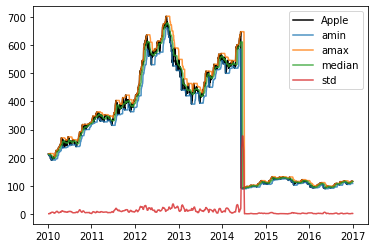

In [47]:
fig, ax = plt.subplots()
ax.plot(aapl, label='Apple', c='k')
ax.plot(features, label=features.columns, alpha=0.8)
ax.legend()
plt.show()

TypeError: unsupported operand type(s) for +: 'slice' and 'int'

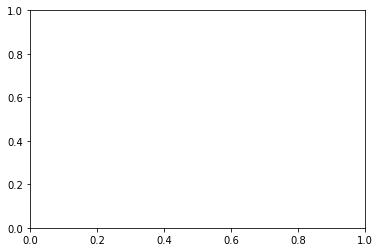

In [48]:
# Import partial from functools
from functools import partial
percentiles = [1, 10, 25, 50, 75, 90, 99]

# Use a list comprehension to create a partial function for each quantile
percentile_functions = [partial(np.percentile, q=percentile) for percentile in percentiles]

# Calculate each of these quantiles on the data using a rolling window
aapl_rolling = aapl.rolling(20, min_periods=5, closed='right')
features_percentiles = aapl.agg(percentile_functions)

# Plot a subset of the result
ax = features_percentiles.loc[:"2011-01"].plot(cmap=plt.cm.viridis)
ax.legend(percentiles, loc=(1.01, .5))
plt.show()

In [ ]:
# Extract date features from the data, add them as columns
aapl['day_of_week'] = aapl.index.dayofweek
aapl['week_of_year'] = aapl.index.weekofyear
aapl['month_of_year'] = aapl.index.month

# Print aapl
print(aapl)

# Timed Delayed Features & Auto regression model

In [49]:
aapl = prices[['AAPL']]

In [50]:
def percent_change(series):
    # Collect all *but* the last value of this window, then the final value
    previous_values = series[:-1]
    last_value = series[-1]

    # Calculate the % difference between the last value and the mean of earlier values
    percent_change = (last_value - np.mean(previous_values)) / np.mean(previous_values)
    return percent_change

prices_prec = aapl['AAPL'].rolling(20).apply(percent_change)

In [51]:
# features form shifting time-sereis
shifts = [*range(1, 11)]

shifts_data = {f'lag_{s}':prices_prec.shift(s) for s in shifts}

shifts_df = pd.DataFrame(shifts_data)

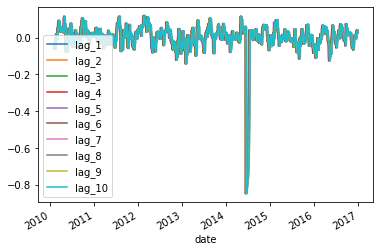

In [52]:
fig, ax = plt.subplots()
shifts_df.plot(ax=ax)
ax.legend()
plt.show()

### Auto regressive model  
Regression from shifted data as features  

In [53]:
from sklearn.linear_model import Ridge
X = shifts_df.fillna(np.nanmedian(shifts_df))
y = prices_prec.fillna(np.nanmedian(prices_prec))

reg = Ridge()
reg.fit(X,y)

Ridge()

<BarContainer object of 10 artists>

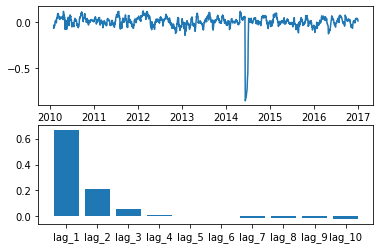

In [54]:
fig, ax = plt.subplots(2,1)
ax[0].plot(prices_prec)
ax[1].bar(X.columns, reg.coef_)

## Cross-validation Time Series  
__Never__ shuffle data, use `KFold` or `TimeSeriesSplit`

In [55]:
X = prices[['EBAY', 'NVDA', 'YHOO']]
y = prices[['AAPL']]

In [56]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=10, shuffle=False)

results = []
X = X.to_numpy()
y = y.to_numpy()

for tr_idx, tt_idx in cv.split(X):
    reg.fit(X[tr_idx], y[tr_idx])
    
    pred = reg.predict(X[tt_idx])
    results.append((pred, tt_idx))

In [57]:
def visualize_predictions(results):
    fig, axs = plt.subplots(2, 1)
    
    for result, tt_idx in results:
        # Plot the indices chosen for validation on each loop
        axs[0].scatter(tt_idx, [0] * len(tt_idx), marker='_', s=2, lw=40)
        axs[0].set(ylim=[-.1, .1], title='Test set indices (color=CV loop)',  xlabel='Index of raw data')
        # Plot the model predictions on each iteration
        axs[1].plot(reg.predict(X[tt_idx]))
        axs[1].set(title='Test set predictions on each CV loop', xlabel='Prediction index')

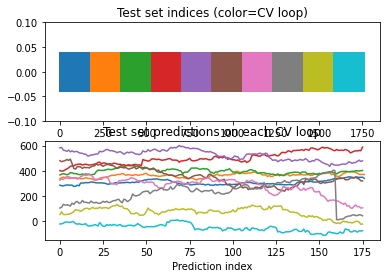

In [58]:
visualize_predictions(results)

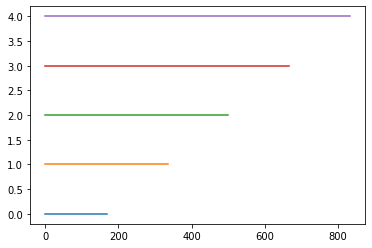

In [59]:
from sklearn.model_selection import TimeSeriesSplit
cv = TimeSeriesSplit(n_splits=5)

X = np.arange(0, 1000)
y = np.repeat(0, 1000)

fig, ax = plt.subplots()
for i, (tr, tt) in enumerate(cv.split(X, y)):
    ax.plot(tr, i+y[tr])

### Check non-stationarity with Bootstrapping

In [71]:
from sklearn.linear_model import Ridge
model = Ridge()

X = prices[['EBAY', 'NVDA', 'YHOO']].to_numpy()
y = prices[['AAPL']].to_numpy()

In [72]:
from sklearn.utils import resample

def bootstrap_interval(data, percentiles=(2.5, 97.5), n_boots=100):
    """Bootstrap a confidence interval for the mean of columns of a 2-D dataset."""
    # Create our empty array to fill the results
    bootstrap_means = np.zeros([n_boots, data.shape[-1]])
    for ii in range(n_boots):
        # Generate random indices for our data *with* replacement, then take the sample mean
        random_sample = resample(data)
        bootstrap_means[ii] = random_sample.mean(axis=0)
        
    # Compute the percentiles of choice for the bootstrapped means
    percentiles = np.percentile(bootstrap_means, percentiles, axis=0)
    return percentiles

In [73]:
# Iterate through CV splits
n_splits = 100
cv = TimeSeriesSplit(n_splits=n_splits)

# Create empty array to collect coefficients
coefficients = np.zeros([n_splits, X.shape[1]])

for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Fit the model on training data and collect the coefficients
    model.fit(X[tr], y[tr])
    coefficients[ii] = model.coef_

ValueError: x and y must be the same size

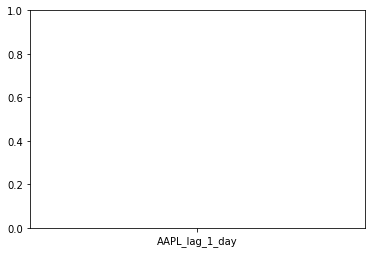

In [77]:
# Calculate a confidence interval around each coefficient
bootstrapped_interval = bootstrap_interval(coefficients)
feature_names = ['AAPL_lag_1_day', 'YHOO_lag_1_day', 'NVDA_lag_1_day', 'AAPL_lag_2_day',
       'YHOO_lag_2_day', 'NVDA_lag_2_day', 'AAPL_lag_3_day', 'YHOO_lag_3_day',
       'NVDA_lag_3_day', 'AAPL_lag_4_day', 'YHOO_lag_4_day', 'NVDA_lag_4_day']
# Plot it
fig, ax = plt.subplots()
ax.scatter(feature_names, bootstrapped_interval[0], marker='_', lw=3)
ax.scatter(feature_names, bootstrapped_interval[1], marker='_', lw=3)
ax.set(title='95% confidence interval for model coefficients')
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

## Model stability with TimeSeriesSplit Test

In [ ]:
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

times_scores = prices.index[:100]
cv_scores = cross_val_score(model, X, y, cv=cv)
scores_series = pd.Series(cv_scores, index=times_scores, name='score')

# Bootstrap a rolling confidence interval for the mean score
scores_lo = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=2.5))
scores_hi = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=97.5))

In [ ]:
# Plot the results
fig, ax = plt.subplots()
scores_lo.plot(ax=ax, label="Lower confidence interval")
scores_hi.plot(ax=ax, label="Upper confidence interval")
ax.legend()
plt.show()

In [ ]:
# Pre-initialize window sizes
window_sizes = [25, 50, 75, 100]

# Create an empty DataFrame to collect the stores
all_scores = pd.DataFrame(index=times_scores)

# Generate scores for each split to see how the model performs over time
for window in window_sizes:
    # Create cross-validation object using a limited lookback window
    cv = TimeSeriesSplit(n_splits=100, max_train_size=window)
    
    # Calculate scores across all CV splits and collect them in a DataFrame
    this_scores = cross_val_score(model, X, y, cv=cv, scoring=my_pearsonr)
    all_scores['Length {}'.format(window)] = this_scores

In [ ]:
# Visualize the scores
ax = all_scores.rolling(10).mean().plot(cmap=plt.cm.coolwarm)
ax.set(title='Scores for multiple windows', ylabel='Correlation (r)')
plt.show()